# Adapting Gradient Descent for Numpy
Adapted from Joel Grus' Data Science from scratch with a numpy implementation by me

In [1]:
import numpy as np
import random

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/sarahcarlisle/anaconda/envs/dsfs/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# define some inputs for doing SGD to find a linear regression fit
# some random observations from 0-20
x_obs = np.random.uniform(0,20,10)

# target variable, x +/- some small noise - so the result of SGD should be ~ 1
y_obs = x_obs + np.random.normal(loc=0,scale=0.1,size=10)

# squared error, linear regression
def sq_error(x, y, beta):
  return (y-(x * beta[0])) ** 2

# gradient of squared error for linear regression
def sq_error_grad(x, y, beta):
  return [(y-(x * beta[0])) * -2]
  

### Original Gradient Descent Code
This code comes from Data Science from Scratch. Available [here](https://github.com/joelgrus/data-science-from-scratch/blob/master/code/gradient_descent.py)

In [4]:
def vector_subtract(v, w):
    """subtracts two vectors componentwise"""
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def scalar_multiply(c, v):
    return [c * v_i for v_i in v]

def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):

    data = zip(x, y)
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

### running SGD for the pure python function from DSFS
converges to something like 1

In [5]:
minimize_stochastic(sq_error, sq_error_grad, x_obs, y_obs, [2])

[0.9960496477378477]

### Implementing using Numpy

In [6]:
def np_minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    """
    Numpy version:
    target_fn: scoring function to minimize sum of across observations
    gradient_fn: the gradient of the target fn with respect to each of
                 the input dimensions of x
    x: training variable(s) as ndarray
    y: target variable as array
    theta_0: starting point
    alpha_0: initial gradient step magnitude
    """
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0
    data_idx = range(0, x.shape[0])

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = target_fn(x, y, theta).sum()

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for i in np.random.choice(data_idx, size=len(data_idx), replace=False):
            #print i
            gradient_i = gradient_fn(x[i,:], y[i], theta)
            #print gradient_i
            theta = theta - (alpha * gradient_i)

    return min_theta

### Testing out the numpy version
I made another dimension for X and a new y s.t. `y2_obs = x_obs + x2_obs + noise`

In [12]:
x2_obs = np.random.uniform(-10,10,10)

X = np.array([x_obs, x2_obs]).T

y2_obs = X.sum(axis=1) + np.random.normal(loc=0,scale=0.1,size=10)

# an error function defined for numpy ndarrays
def multi_error(x, y, beta):
    return (y - np.matmul(beta,x.T))

# squared error
def sq_error_multi(x, y, beta):
    return np.square(multi_error(x, y, beta)) 

# the gradient for this numpy version of the squared error
def sq_error_multi_grad(x, y, beta):
    return -x * multi_error(x,y,beta)

Plotting new y vs the row-wise sum of X. Looks basically linear. 

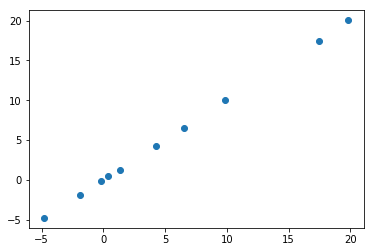

In [13]:
plt.scatter(x=X.sum(axis=1), y=y2_obs)

Run my numpy SGD with an initial guess of 5,5 for the coefficients on x, x2. Converges to something like 1,1

In [14]:
np_minimize_stochastic(sq_error_multi, sq_error_multi_grad, X, y2_obs, np.array([5,5]))

array([1.0046187 , 1.00395797])